## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [264]:
import string
import numpy as np
import os
import string
import re
import time
import torch
import typing
from IPython.display import clear_output
from random import sample
import matplotlib.pyplot as plt
%matplotlib inline

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [265]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [266]:
translator = str.maketrans('', '', string.punctuation + string.digits + '–'+ '’'+'…'+'€'+'—')
def remove_puncts(input_string):
    return input_string.translate(translator)


In [267]:
MAX_LENGTH = max(map(len, text))
MAX_LENGTH

63

In [271]:
def get_normal_text(text):
  text5 = []
  for sentence in text:
    if(30 <= len(sentence) and len(sentence)<= 63):
      text5.append(remove_puncts(sentence.lower()))
  join_str = "".join(text5)
  str_count = (int)(len(join_str)/MAX_LENGTH)
  text4 = []
  for i in range(0, str_count*MAX_LENGTH, MAX_LENGTH):
    text4.append(join_str[i:i+MAX_LENGTH])
  return text4
normal_text = get_normal_text(text)
normal_text

['  from fairest creatures we desire increase\n  that thereby beau',
 'tys rose might never die\n  but as the riper should by time dece',
 'ase\n  his tender heir might bear his memory\n  but thou contract',
 'ed to thine own bright eyes\n  feedst thy lights flame with self',
 'substantial fuel\n  making a famine where abundance lies\n  thy s',
 'elf thy foe to thy sweet self too cruel\n  thou that art now the',
 ' worlds fresh ornament\n  and only herald to the gaudy spring\n  ',
 'within thine own bud buriest thy content\n  and tender churl mak',
 'st waste in niggarding\n    pity the world or else this glutton ',
 'be\n    to eat the worlds due by the grave and thee\n  when forty',
 ' winters shall besiege thy brow\n  and dig deep trenches in thy ',
 'beautys field\n  thy youths proud livery so gazed on now\n  will ',
 'be a tatterd weed of small worth held\n  then being asked where ',
 'all thy beauty lies\n  where all the treasure of thy lusty days\n',
 '  to say within thine own 

### Data loading: "Евгений Онегин"


In [269]:
#!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
#    
#with open('onegin.txt', 'r') as iofile:
#    text6 = iofile.readlines()
#    
#text6 = [x.replace('\t\t', '') for x in text6]#
#

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [6]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here


Put all the characters, that you've seen in the text, into variable `tokens`.

In [272]:
tokens = set("".join(normal_text))
tokens.add('<pad>')
tokens = sorted(list(tokens))
num_tokens = len(tokens)

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [273]:
# dict <index>:<char>
# Your great code here
id_to_token = dict(list(enumerate(tokens)))

# dict <char>:<index>
# Your great code here
token_to_id = dict([(token, idx) for idx, token in id_to_token.items()])
PAD_IDX = token_to_id['<pad>']

In [274]:
token_to_id

{'\n': 0,
 ' ': 1,
 '<pad>': 2,
 'a': 3,
 'b': 4,
 'c': 5,
 'd': 6,
 'e': 7,
 'f': 8,
 'g': 9,
 'h': 10,
 'i': 11,
 'j': 12,
 'k': 13,
 'l': 14,
 'm': 15,
 'n': 16,
 'o': 17,
 'p': 18,
 'q': 19,
 'r': 20,
 's': 21,
 't': 22,
 'u': 23,
 'v': 24,
 'w': 25,
 'x': 26,
 'y': 27,
 'z': 28}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [275]:
def word_from_tokens(tokens):
     return np.array([token_to_id[token] for token in tokens])


def sentectence_to_tokens(batch):
    return np.concatenate(list(map(word_from_tokens, batch)))

In [276]:
def to_matrix(text: typing.List[str], max_len: int=None, pad: int=PAD_IDX, dtype: str='int32', batch_first: bool=True):
    size = max_len or max(map(len, text))
    matrix = np.zeros([len(text), size], dtype) + pad
    for i in range(len(text)):
        line_ix = sentectence_to_tokens([text[i]])
        matrix[i, :len(line_ix)] = line_ix
    if not batch_first:
        matrix = np.transpose(matrix)
    return torch.tensor(matrix, dtype=torch.int64)

In [ ]:
from pprint import pprint

pprint(normal_text[:5])
transformed_text1 = to_matrix(normal_text[:5])
pprint(transformed_text1)

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [278]:
# Your code here
import torch, torch.nn as nn
import torch.nn.functional as F

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [279]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        self.x_emb = x_emb
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=1)
        h_next = self.rnn_update(x_and_h)
        self.x_and_h = x_and_h
        
        h_next = torch.tanh(h_next)
        self.h_next = h_next
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        self.logits = logits
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [280]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss(ignore_index=PAD_IDX)
opt = torch.optim.Adam(char_rnn.parameters(), lr=0.001)
opt.zero_grad()
history = []

In [281]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

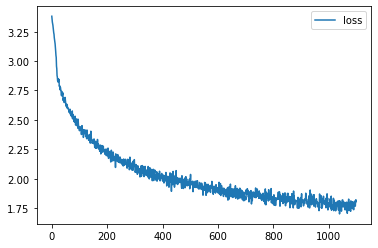

In [283]:
MAX_LENGTH = 63

for i in range(1000):
    batch_ix = to_matrix(sample(normal_text, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    loss = criterion(
      predictions_logp.contiguous().view(-1, len(tokens)),
      actual_next_tokens.contiguous().view(-1)
    )
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [284]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=500, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [292]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print("Temperature =", t)
    print(generate_sample(char_rnn, seed_phrase="love death", temperature=t))
    print('\n')

Temperature = 0.1
love death the shand the shall the shand the sourt the stere the shall the shand the shand the shall the sare the shall the shand the shall the shand the shall the shall the shand the stere the shall the shand the shall the should the with the shand the with the shall the stere the shand the stere the sourt the sour the shand the stere the shall the shall the shand the shall the shand the stere the shall the stere the shall the shand the shall the sourt the shall the shanter the shand the shand 


Temperature = 0.2
love death the me so the will the with the my seath the same the beart the sters should the beart the shall the sto the beart of the seart the beauty seet the for the so the sters the stert the may she sters thy shand the with the will the reade the store the should my some the sume the should the stere in the sour my say she the seart in the with the should i and the the sall of the sure the sure the the should the shall when the should the shand of the so

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [286]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        self.rnn_num_units = rnn_num_units
        
    def forward(self, x, state=None):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, state = self.rnn(self.emb(x), state)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return state, next_logp
    def initial_state(self, batch_size) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        return (
            torch.zeros(1, batch_size, self.rnn_num_units, requires_grad=True),
            torch.zeros(1, batch_size, self.rnn_num_units, requires_grad=True)
        )
    
model = CharRNNLoop()
criterion = nn.NLLLoss(ignore_index=PAD_IDX)
opt = torch.optim.Adam(model.parameters())
history = []

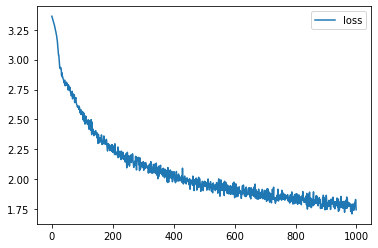

In [287]:
MAX_LENGTH = 63

for i in range(1000):
    batch_ix = to_matrix(sample(normal_text, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    state, logp_seq = model(batch_ix)
    
    # compute loss
    #<YOUR CODE>
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens), 
        actual_next_tokens.contiguous().view(-1)
        )
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [288]:
def generate_sample1(model, seed_phrase=' ', max_length=400, temperature=1.0):
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.long)
    states = model.initial_state(batch_size=1)
    
    for i in range(len(seed_phrase) - 1):
        states, _ = model(x_sequence[:, :, i], states)

    for _ in range(max_length - len(seed_phrase)):
        states, out = model(x_sequence[:,:, -1], states)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0].ravel()
        
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.long)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [295]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print("Temperature =", t)
    print(generate_sample1(model, seed_phrase="love death", temperature=t))
    print('\n')

Temperature = 0.1
love death the shall the sing the shand the shall the with the shall the shall the sing the shate the shall the shate the shall the beart the shall the shate the shate the shate the shall the shall the shall the shate the shall the sheet the the with the shall the shate the shand the shand the shall the the shand the shate the shall the shall the shall the shall the shall the shate the come the sh


Temperature = 0.2
love death the sheart the shall the the deart and the come the deart the grove the with the shall the do the shand the store the singe the sheet the beart the cones the frouss the shall thou the beart the shand the shall the with my steet the my love the the beart the shate the my shall the the the shall me the me the the sheart the san the shand the sall the shall the with the sing the shall the 


Temperature = 0.5
love death the but the for the bears whought the preaty love so stare the bea the sheart she alls and make and the frace the bre the core an

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [302]:
# Saving and loading code here
torch.save(model.state_dict(), 'my_poetry.pth')

In [303]:
new_model = CharRNNLoop()
new_model.load_state_dict(torch.load('my_poetry.pth'))
new_model.eval()

CharRNNLoop(
  (emb): Embedding(29, 16)
  (rnn): LSTM(16, 64, batch_first=True)
  (hid_to_logits): Linear(in_features=64, out_features=29, bias=True)
)

In [304]:
print(generate_sample1(new_model, max_length=500, temperature=1))

 it me delfedn
  at by wy deokulf a thy malsiked of firth in sight me hang of fot thach heevelmeed a fraotery my mink how most soul mus
  who livig may uive
  which sayd gorn
   a enend
  s whee to my he slive tay inteldss thy to thes botht outh
  be out gopment wace thy faltest deate beaute thices oug
  tho urt my lifed fiths shart
  this mught sages in leaunt thrit thousredecadest hinges to tut thou will being rist weenors ile
    stall stauthich gonllily as
  deft leagt fronfig my stuon all h


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)